In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/Tugas_Akhir/virufy-covid-main/cough

/content/gdrive/MyDrive/Tugas_Akhir/virufy-covid-main/cough


In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2
import os
import json
import pickle
import os
from os import listdir

---
# 1-Prepare Data
---



## Download Data

In [ ]:
!git clone https://github.com/iiscleap/Coswara-Data.git

Cloning into 'Coswara-Data'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 762 (delta 14), reused 35 (delta 14), pack-reused 726
Receiving objects: 100% (762/762), 13.99 GiB | 19.87 MiB/s, done.
Resolving deltas: 100% (301/301), done.
Checking out files: 100% (178/178), done.


In [ ]:
rt_dir = 'Coswara-Data/'
import glob
for each in os.listdir(rt_dir):
    if os.path.isdir(os.path.join(rt_dir,each)) and each != '.git':
        print(each)
        !cat {os.path.join(rt_dir, each,'')}*.tar.gz.* > {os.path.join(rt_dir, each,'')}combined_file.tar.gz
        !tar -xzf {os.path.join(rt_dir, each,'')}combined_file.tar.gz -C {rt_dir}
subset = glob.glob('/content/Coswara-Data/*/*.tar.gz.*') + glob.glob('/content/Coswara-Data/*/combined_data.tar.gz')
[os.remove(x) for x in subset];

20200413
20200415
20200416
20200417
20200418
20200419
20200424
20200430
20200502
20200504
20200505
20200525
20200604
20200707
20200720
20200803
20200814
20200820
20200824
20200901
20200911
20200919
20200930
20201012
20201031
20201130
20201221
20210206
20210406
20210419
20210426
20210507
20210523
20210603
20210618
20210630
20210714
20210816
20210830
20210914
20210930


In [ ]:
!wget https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
!mv public_dataset.zip?download=1 public_dataset.zip
!unzip -q public_dataset.zip
!mkdir 'custom_dataset'

--2021-11-03 12:03:10--  https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 951442487 (907M) [application/octet-stream]
Saving to: ‘public_dataset.zip?download=1’

public_dataset.zip? 100%[===================>] 907.37M  1.44MB/s    in 2m 51s  

2021-11-03 12:06:08 (5.29 MB/s) - ‘public_dataset.zip?download=1’ saved [951442487/951442487]



In [4]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR','DataSet']
join_by = pd.read_csv('Coswara-Data/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('Coswara-Data/*/*/cough-shallow.wav')):
  temp = pd.DataFrame(columns=['id','DIR'])
  temp['id'] = [path.split('/')[-2]]
  temp['DIR'] = [path]
  temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

  temp['fomp']= (temp['fever']| temp['mp']).apply(int)
  temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
  temp        = temp[['id','covid_status','DIR','fomp','oths']]
  df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR','fomp':'Fever/MP','oths':'ORC'}))
CosData=pd.concat(df_list)
CosData['DataSet'] = 'coswara'
CosData.head()
CosData.to_csv('Coswara_dataset.csv')

100%|██████████| 2232/2232 [00:26<00:00, 83.87it/s]


In [5]:
CosData = pd.read_csv('Coswara_dataset.csv')

## Prepare dataset

In [6]:
coughvid  = 'public_dataset/'
custpath  = 'custom_dataset/' #Where mel spec images will be stored

VidData   = pd.read_csv(os.path.join(coughvid,'metadata_compiled.csv'),header=0)
VidData   = VidData.loc[VidData['cough_detected'] >= 0.9][['uuid','fever_muscle_pain','respiratory_condition','status']]
VidData.dropna(inplace=True)

extradata = VidData.loc[VidData['status']=='COVID-19']
notradata = VidData.loc[VidData['status']!='COVID-19'][0:1000]

TotData   = pd.concat([extradata,notradata],ignore_index= True)
TotData['DIR'] = coughvid + TotData['uuid'] + '.webm'
TotData['DataSet'] = 'coughvid'
TotData['fever_muscle_pain']    = TotData['fever_muscle_pain'].apply(int)
TotData['respiratory_condition']= TotData['respiratory_condition'].apply(int)
TotData   = pd.concat([CosData,TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})])
TotData   = TotData.sample(frac=1).reset_index(drop=True)
TotData.head()
TotData.to_csv('Total_Datase.csv')

In [6]:
TotData = pd.read_csv('Total_Datase.csv')

## Feature Extraction

In [7]:
def feature_extractor(row):

  name     = row[0]
  try:
    audio,sr = librosa.load(row[-4])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=39)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    pylab.axis('off') # no axis
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpath,name+'.png')
    pylab.savefig(savepath, bbox_inches=None, pad_inches=0)
    pylab.close()
  except:
    print('File cannot open')
    return None,None
  return mfccsscaled,savepath

features = []
diagnoses= []
imgpaths = []

In [8]:
for row in tqdm(TotData.values):
  mfccs,savepath  = feature_extractor(row)
  features.append(mfccs)
  imgpaths.append(savepath)
  diagnoses.append([row[3],row[4]])

  0%|          | 3/3673 [00:06<2:03:14,  2.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 5/3673 [00:10<2:03:59,  2.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 6/3673 [00:12<1:57:52,  1.93s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 14/3673 [00:25<1:41:10,  1.66s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 16/3673 [00:27<1:16:25

File cannot open


  1%|          | 22/3673 [00:37<1:38:36,  1.62s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 23/3673 [00:39<1:40:14,  1.65s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 26/3673 [00:45<1:54:12,  1.88s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 30/3673 [00:51<1:41:53,  1.68s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 31/3673 [00:52<1:14

File cannot open


  1%|          | 35/3673 [00:59<1:40:36,  1.66s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 37/3673 [01:03<1:48:44,  1.79s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 39/3673 [01:06<1:50:47,  1.83s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 44/3673 [01:15<1:47:07,  1.77s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 45/3673 [01:16<1:17

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|▏         | 46/3673 [01:17<1:27:40,  1.45s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|▏         | 47/3673 [01:19<1:31:11,  1.51s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|▏         | 49/3673 [01:22<1:28:16,  1.46s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|▏         | 50/3673 [01:24<1:36:02,  1.59s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|▏         | 55/3673 [01:30<1:21:32,  1.35s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 58/3673 [01:35<1:27:02,  1.44s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 60/3673 [01:39<1:33:30,  1.55s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 63/3673 [01:43<1:36:41,  1.61s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▋         | 232/3673 [06:38<1:31:58,  1.60s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▋         | 233/3673 [06:40<1:26:07,  1.50s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▋         | 234/3673 [06:42<1:31:22,  1.59s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▋         | 236/3673 [06:45<1:32:48,  1.62s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


  7%|▋         | 265/3673 [07:32<1:28:56,  1.57s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 268/3673 [07:36<1:26:24,  1.52s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 270/3673 [07:39<1:26:23,  1.52s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 271/3673 [07:41<1:25:31,  1.51s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 272/3673 [07:42

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▊         | 314/3673 [08:50<1:22:58,  1.48s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▊         | 317/3673 [08:56<1:46:45,  1.91s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▊         | 319/3673 [08:59<1:40:55,  1.81s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▊         | 321/3673 [09:03<1:37:34,  1.75s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 373/3673 [10:30<1:15:20,  1.37s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 374/3673 [10:32<1:24:34,  1.54s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 375/3673 [10:33<1:28:42,  1.61s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 377/3673 [10:37<1:34:13,  1.72s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 382/3673 [10:44<1:20:06,  1.46s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 385/3673 [10:49<1:22:46,  1.51s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 386/3673 [10:51<1:31:22,  1.67s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 387/3673 [10:53<1:36:33,  1.76s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 517/3673 [14:34<1:21:27,  1.55s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 519/3673 [14:38<1:27:22,  1.66s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 523/3673 [14:44<1:20:42,  1.54s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 524/3673 [14:44<1:01:26,  1.17s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 531/3673 [14:56<1:30:20,  1.73s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 532/3673 [14:58<1:33:38,  1.79s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 533/3673 [15:00<1:35:07,  1.82s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 534/3673 [15:02<1:33:51,  1.79s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


 16%|█▌        | 585/3673 [16:32<1:09:01,  1.34s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 587/3673 [16:34<1:12:33,  1.41s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 594/3673 [16:47<1:26:02,  1.68s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▋        | 598/3673 [16:54<1:25:38,  1.67s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▋        | 603/3673 [17:03

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 619/3673 [17:29<1:11:00,  1.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 623/3673 [17:35<1:14:18,  1.46s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 624/3673 [17:37<1:19:32,  1.57s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 626/3673 [17:41<1:34:01,  1.85s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


 19%|█▉        | 713/3673 [20:17<1:10:10,  1.42s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 723/3673 [20:33<1:20:53,  1.65s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 724/3673 [20:35<1:25:06,  1.73s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 725/3673 [20:37<1:28:24,  1.80s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 727/3673 [20:40

File cannot open


 21%|██        | 755/3673 [21:29<1:10:11,  1.44s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 757/3673 [21:33<1:19:21,  1.63s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 759/3673 [21:36<1:18:32,  1.62s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 760/3673 [21:38<1:24:54,  1.75s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 762/3673 [21:42

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 837/3673 [23:48<1:16:29,  1.62s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 838/3673 [23:50<1:20:32,  1.70s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 843/3673 [23:59<1:21:02,  1.72s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 845/3673 [24:03<1:21:33,  1.73s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


 24%|██▎       | 865/3673 [24:36<1:07:34,  1.44s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 866/3673 [24:38<1:16:43,  1.64s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 867/3673 [24:40<1:18:33,  1.68s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 868/3673 [24:40<1:00:34,  1.30s/it]

File cannot open


 24%|██▎       | 869/3673 [24:42<1:06:25,  1.42s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 870/3673 [24:44<1:15:12,  1.61s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 872/3673 [24:48<1:25:13,  1.83s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 879/3673 [24:59<1:15:10,  1.61s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 880/3673 [25:01

File cannot open


 27%|██▋       | 976/3673 [27:47<1:02:28,  1.39s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 979/3673 [27:53<1:14:00,  1.65s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 980/3673 [27:54<1:10:58,  1.58s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 981/3673 [27:56<1:15:41,  1.69s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 983/3673 [28:00

File cannot open


 27%|██▋       | 993/3673 [28:17<1:10:25,  1.58s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 995/3673 [28:20<1:18:11,  1.75s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 996/3673 [28:23<1:24:13,  1.89s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 997/3673 [28:24<1:21:54,  1.84s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 999/3673 [28:28

File cannot open


 29%|██▉       | 1059/3673 [30:14<1:06:11,  1.52s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1060/3673 [30:16<1:13:13,  1.68s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1066/3673 [30:26<1:16:40,  1.76s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1067/3673 [30:28<1:20:40,  1.86s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1068/3673 [

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1131/3673 [32:23<1:05:52,  1.55s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1133/3673 [32:27<1:13:49,  1.74s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1136/3673 [32:32<1:12:35,  1.72s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1137/3673 [32:34<1:15:25,  1.78s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 1277/3673 [36:57<1:05:35,  1.64s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 1279/3673 [37:01<1:08:29,  1.72s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▌      | 1290/3673 [37:20<1:07:26,  1.70s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▌      | 1292/3673 [37:23<1:08:38,  1.73s/it]/usr/local/lib/python3.7/dis

File cannot open


 38%|███▊      | 1385/3673 [40:21<1:01:22,  1.61s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 1390/3673 [40:30<1:06:02,  1.74s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 1394/3673 [40:38<1:09:17,  1.82s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 1395/3673 [40:40<1:13:43,  1.94s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 1398/3673 [

File cannot open


 41%|████      | 1489/3673 [43:31<55:00,  1.51s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████      | 1492/3673 [43:37<1:00:55,  1.68s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████      | 1493/3673 [43:39<1:07:20,  1.85s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████      | 1494/3673 [43:41<1:04:51,  1.79s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████      | 1495/3673 [43

File cannot open


 42%|████▏     | 1541/3673 [45:13<56:25,  1.59s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 1542/3673 [45:15<1:05:13,  1.84s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 1546/3673 [45:22<1:02:52,  1.77s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 1550/3673 [45:29<1:01:24,  1.74s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 1551/3673 [45

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 1570/3673 [46:09<1:03:25,  1.81s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 1572/3673 [46:13<59:22,  1.70s/it]  /usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 1573/3673 [46:15<1:05:56,  1.88s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 1574/3673 [46:16<52:56,  1.51s/it]  

File cannot open


 43%|████▎     | 1575/3673 [46:17<54:22,  1.55s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 1576/3673 [46:20<1:01:35,  1.76s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 1577/3673 [46:22<1:08:46,  1.97s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 1583/3673 [46:33<1:00:59,  1.75s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 1585/3673 [46

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 1591/3673 [46:47<1:00:03,  1.73s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 1593/3673 [46:51<1:02:29,  1.80s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 1597/3673 [46:59<1:03:14,  1.83s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▎     | 1598/3673 [47:01<1:09:53,  2.02s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▍     | 1608/3673 [47:19<57:03,  1.66s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▍     | 1610/3673 [47:23<58:14,  1.69s/it]  /usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▍     | 1612/3673 [47:28<1:10:59,  2.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▍     | 1613/3673 [47:30<1:12:39,  2.12s/it]/usr/local/lib/python3.7/dist-

File cannot open


 46%|████▌     | 1685/3673 [49:41<45:59,  1.39s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▌     | 1686/3673 [49:43<55:01,  1.66s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▌     | 1687/3673 [49:45<58:31,  1.77s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▌     | 1689/3673 [49:48<58:12,  1.76s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▌     | 1691/3673 [49:52<59

File cannot open


 46%|████▋     | 1704/3673 [50:15<46:25,  1.41s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▋     | 1706/3673 [50:17<41:27,  1.26s/it]

File cannot open


 47%|████▋     | 1708/3673 [50:20<46:12,  1.41s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 1709/3673 [50:22<51:15,  1.57s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 1710/3673 [50:24<57:38,  1.76s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 1712/3673 [50:28<59:14,  1.81s/it]  /usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 1724/3673 [50:49<

File cannot open


 48%|████▊     | 1753/3673 [51:43<51:17,  1.60s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 1757/3673 [51:49<54:38,  1.71s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 1758/3673 [51:52<1:00:09,  1.88s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 1761/3673 [51:59<1:12:27,  2.27s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 1764/3673 [52:0

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|████▉     | 1819/3673 [53:50<52:52,  1.71s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|████▉     | 1822/3673 [53:56<53:37,  1.74s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|████▉     | 1828/3673 [54:05<46:26,  1.51s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|████▉     | 1831/3673 [54:10<49:14,  1.60s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|█████     | 1847/3673 [54:37<39:15,  1.29s/it]

File cannot open


 50%|█████     | 1848/3673 [54:37<29:39,  1.03it/s]

File cannot open


 50%|█████     | 1850/3673 [54:40<38:21,  1.26s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|█████     | 1851/3673 [54:43<49:17,  1.62s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|█████     | 1853/3673 [54:46<49:47,  1.64s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 1858/3673 [54:56<58:16,  1.93s/it]  /usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 1860/3673 [55:01<

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 1871/3673 [55:19<39:55,  1.33s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 1872/3673 [55:21<47:24,  1.58s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 1873/3673 [55:23<55:19,  1.84s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 1875/3673 [55:27<53:35,  1.79s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 1876/3673 [55:29<56:35,  1.89s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


 52%|█████▏    | 1921/3673 [56:57<48:51,  1.67s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 1930/3673 [57:13<49:15,  1.70s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 1931/3673 [57:15<55:14,  1.90s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 1932/3673 [57:18<56:49,  1.96s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 1933/3673 [57:20<1:

File cannot open


 53%|█████▎    | 1962/3673 [58:15<47:48,  1.68s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 1964/3673 [58:20<57:41,  2.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 54%|█████▎    | 1967/3673 [58:25<53:27,  1.88s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 54%|█████▎    | 1969/3673 [58:29<55:18,  1.95s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 54%|█████▎    | 1970/3673 [58:32<1:

File cannot open


 54%|█████▍    | 1992/3673 [59:14<53:27,  1.91s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 54%|█████▍    | 1993/3673 [59:16<56:53,  2.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 54%|█████▍    | 2001/3673 [59:31<47:34,  1.71s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 55%|█████▍    | 2002/3673 [59:33<54:00,  1.94s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 55%|█████▍    | 2007/3673 [59:41<46

File cannot open


 55%|█████▌    | 2024/3673 [1:00:15<52:17,  1.90s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 55%|█████▌    | 2026/3673 [1:00:19<52:37,  1.92s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 55%|█████▌    | 2029/3673 [1:00:25<53:22,  1.95s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 55%|█████▌    | 2030/3673 [1:00:28<56:28,  2.06s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 55%|█████▌    | 2032/3673 [

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 55%|█████▌    | 2038/3673 [1:00:44<52:41,  1.93s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 56%|█████▌    | 2045/3673 [1:00:56<45:54,  1.69s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 56%|█████▌    | 2049/3673 [1:01:03<45:51,  1.69s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 56%|█████▌    | 2052/3673 [1:01:09<50:50,  1.88s/it]/usr/local/lib/python3.7/dis

File cannot open


 58%|█████▊    | 2123/3673 [1:03:34<38:39,  1.50s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 2126/3673 [1:03:39<41:45,  1.62s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 2127/3673 [1:03:41<47:00,  1.82s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 2128/3673 [1:03:44<51:41,  2.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 2129/3673 [

File cannot open


 58%|█████▊    | 2144/3673 [1:04:17<38:54,  1.53s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 2145/3673 [1:04:19<47:25,  1.86s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 2146/3673 [1:04:20<39:17,  1.54s/it]

File cannot open


 59%|█████▊    | 2149/3673 [1:04:24<36:26,  1.43s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▊    | 2152/3673 [1:04:30<43:55,  1.73s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▊    | 2156/3673 [1:04:38<48:32,  1.92s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▉    | 2160/3673 [1:04:46<45:39,  1.81s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▉    | 2162/3673 [

File cannot open


 60%|█████▉    | 2196/3673 [1:05:57<42:37,  1.73s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|█████▉    | 2197/3673 [1:05:59<46:36,  1.89s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|█████▉    | 2201/3673 [1:06:06<42:30,  1.73s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|█████▉    | 2202/3673 [1:06:09<49:10,  2.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|██████    | 2208/3673 [

File cannot open


 61%|██████▏   | 2255/3673 [1:07:54<37:41,  1.59s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 61%|██████▏   | 2258/3673 [1:08:00<44:43,  1.90s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 62%|██████▏   | 2260/3673 [1:08:06<55:48,  2.37s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 62%|██████▏   | 2264/3673 [1:08:13<46:12,  1.97s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 62%|██████▏   | 2265/3673 [

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▎   | 2340/3673 [1:10:46<41:38,  1.87s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▍   | 2342/3673 [1:10:51<47:06,  2.12s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▍   | 2343/3673 [1:10:54<50:46,  2.29s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▍   | 2344/3673 [1:10:56<51:34,  2.33s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 2409/3673 [1:13:17<39:48,  1.89s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 2411/3673 [1:13:21<41:23,  1.97s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 2412/3673 [1:13:24<46:13,  2.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 2414/3673 [1:13:28<42:06,  2.01s/it]/usr/local/lib/python3.7/dis

File cannot open


 66%|██████▌   | 2427/3673 [1:13:55<37:20,  1.80s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 2429/3673 [1:14:00<40:51,  1.97s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 2430/3673 [1:14:03<45:57,  2.22s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 2431/3673 [1:14:05<48:50,  2.36s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 2432/3673 [

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 2461/3673 [1:15:09<39:50,  1.97s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 2462/3673 [1:15:10<33:29,  1.66s/it]

File cannot open


 67%|██████▋   | 2464/3673 [1:15:13<31:38,  1.57s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 2470/3673 [1:15:23<31:02,  1.55s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 2471/3673 [1:15:25<37:55,  1.89s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 2474/3673 [1:15:30<27:51,  1.39s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 2476/3673 [1:15:34<36:29,  1.83s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 2477/3673 [1:15:36<39:35,  1.99s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 68%|██████▊   | 2480/3673 [1:15:43<38:41,  1.95s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 68%|██████▊   | 2486/3673 [1:15:54<34:16,  1.73s/it]/usr/local/lib/python3.7/dis

File cannot open


 69%|██████▉   | 2549/3673 [1:18:05<39:34,  2.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 69%|██████▉   | 2550/3673 [1:18:08<42:46,  2.29s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 70%|██████▉   | 2554/3673 [1:18:16<38:55,  2.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 70%|██████▉   | 2557/3673 [1:18:23<37:08,  2.00s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 70%|██████▉   | 2561/3673 [

File cannot open


 71%|███████   | 2603/3673 [1:19:57<32:09,  1.80s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████   | 2605/3673 [1:20:01<35:46,  2.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████   | 2606/3673 [1:20:04<38:07,  2.14s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████   | 2610/3673 [1:20:12<34:43,  1.96s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████   | 2613/3673 [

File cannot open


 71%|███████▏  | 2618/3673 [1:20:25<23:48,  1.35s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████▏  | 2619/3673 [1:20:27<31:15,  1.78s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████▏  | 2620/3673 [1:20:30<36:10,  2.06s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████▏  | 2621/3673 [1:20:33<38:35,  2.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████▏  | 2624/3673 [

File cannot open


 72%|███████▏  | 2640/3673 [1:21:11<31:55,  1.85s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2642/3673 [1:21:15<33:49,  1.97s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2645/3673 [1:21:22<35:32,  2.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2647/3673 [1:21:26<33:51,  1.98s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 2648/3673 [

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▍  | 2714/3673 [1:23:39<25:15,  1.58s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▍  | 2718/3673 [1:23:47<27:33,  1.73s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▍  | 2721/3673 [1:23:53<28:18,  1.78s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▍  | 2725/3673 [1:24:00<27:29,  1.74s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 3001/3673 [1:34:07<22:46,  2.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 3002/3673 [1:34:10<23:44,  2.12s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 3005/3673 [1:34:17<23:56,  2.15s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 3007/3673 [1:34:22<25:08,  2.26s/it]/usr/local/lib/python3.7/dis

File cannot open


 83%|████████▎ | 3041/3673 [1:35:28<18:51,  1.79s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 3054/3673 [1:35:52<17:53,  1.73s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 3058/3673 [1:36:00<18:26,  1.80s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 3061/3673 [1:36:06<18:31,  1.82s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 3063/3673 [

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▍ | 3100/3673 [1:37:26<20:05,  2.10s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▍ | 3105/3673 [1:37:35<16:54,  1.79s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▍ | 3108/3673 [1:37:41<18:15,  1.94s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▍ | 3109/3673 [1:37:44<20:53,  2.22s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▌ | 3145/3673 [1:39:03<18:13,  2.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▌ | 3146/3673 [1:39:06<20:48,  2.37s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▌ | 3151/3673 [1:39:16<16:03,  1.85s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▌ | 3152/3673 [1:39:19<19:22,  2.23s/it]/usr/local/lib/python3.7/dis

File cannot open


 86%|████████▋ | 3174/3673 [1:40:09<15:24,  1.85s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▋ | 3175/3673 [1:40:12<17:54,  2.16s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▋ | 3177/3673 [1:40:17<17:52,  2.16s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 3178/3673 [1:40:24<30:42,  3.72s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 3180/3673 [

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 3186/3673 [1:40:41<16:35,  2.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 3189/3673 [1:40:46<12:53,  1.60s/it]

File cannot open


 87%|████████▋ | 3195/3673 [1:40:56<12:39,  1.59s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 3198/3673 [1:41:02<14:11,  1.79s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 3199/3673 [1:41:05<17:08,  2.17s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 3201/3673 [1:41:11<20:07,  2.56s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 3204/3673 [

File cannot open


 88%|████████▊ | 3246/3673 [1:42:46<13:33,  1.90s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 89%|████████▊ | 3251/3673 [1:42:57<13:36,  1.94s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 89%|████████▊ | 3252/3673 [1:42:59<15:31,  2.21s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 89%|████████▊ | 3253/3673 [1:43:03<17:27,  2.49s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 89%|████████▊ | 3259/3673 [

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 89%|████████▉ | 3273/3673 [1:43:44<12:52,  1.93s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 89%|████████▉ | 3276/3673 [1:43:50<13:10,  1.99s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 89%|████████▉ | 3278/3673 [1:43:54<12:53,  1.96s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 89%|████████▉ | 3280/3673 [1:43:59<13:39,  2.08s/it]/usr/local/lib/python3.7/dis

File cannot open


 90%|████████▉ | 3300/3673 [1:44:41<10:54,  1.75s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|████████▉ | 3301/3673 [1:44:44<13:21,  2.15s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|████████▉ | 3303/3673 [1:44:49<14:19,  2.32s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|████████▉ | 3304/3673 [1:44:52<15:53,  2.59s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|████████▉ | 3305/3673 [

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 3341/3673 [1:46:16<10:53,  1.97s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 3343/3673 [1:46:21<11:37,  2.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 3349/3673 [1:46:32<09:05,  1.68s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████▏| 3352/3673 [1:46:38<09:35,  1.79s/it]/usr/local/lib/python3.7/dis

File cannot open


 93%|█████████▎| 3430/3673 [1:49:30<08:16,  2.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▎| 3436/3673 [1:49:42<07:05,  1.79s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▎| 3437/3673 [1:49:45<08:39,  2.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▎| 3438/3673 [1:49:49<09:47,  2.50s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▎| 3439/3673 [

File cannot open


 96%|█████████▌| 3516/3673 [1:52:39<04:21,  1.66s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 3517/3673 [1:52:42<05:48,  2.23s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 3518/3673 [1:52:46<06:56,  2.69s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 3523/3673 [1:52:58<05:59,  2.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 3531/3673 [

File cannot open


 97%|█████████▋| 3564/3673 [1:54:29<03:58,  2.19s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 3569/3673 [1:54:40<03:36,  2.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 3570/3673 [1:54:43<04:04,  2.37s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 3571/3673 [1:54:47<04:41,  2.76s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 3572/3673 [

##Save Data Array

In [9]:
os.mkdir('data/')

In [10]:
pickle.dump( features, open( "data/features.pickle", "wb" ) )
pickle.dump( imgpaths, open( "data/imgpaths.pickle", "wb" ) )
pickle.dump( diagnoses, open( "data/diagnoses.pickle", "wb" ) )

---
# 2- Data Sampling 
---

In [7]:
with open("data/features.pickle", "rb") as fp:   # Unpickling
     features = pickle.load(fp)

with open("data/imgpaths.pickle", "rb") as fp:   # Unpickling
     imgpaths = pickle.load(fp)

with open("data/diagnoses.pickle", "rb") as fp:   # Unpickling
     diagnoses = pickle.load(fp)

## Remove Nans





In [8]:
isnone = lambda x: x is not None
label  = lambda x: 1 if x == 'positive_mild' or x =='positive_moderate' or x == 'COVID-19' else 0
cast_x = list(map(isnone,features))
data_y = list(map(label,TotData['STATUS']))

data_x = [features[i] for i in range(len(features)) if cast_x[i] == True]
data_xx= [imgpaths[i] for i in range(len(imgpaths)) if cast_x[i] == True]
data_xp= [diagnoses[i]for i in range(len(diagnoses))if cast_x[i] == True]
data_y = [data_y[i] for i in range(len(features)) if cast_x[i] == True]

## Prepare Data Splits
  n = NUM_shuf





In [16]:
assert len(data_x) == len(data_xx) == len(data_xp), "Data lengths do not match"

indices = np.arange(len(data_x))
NUM_shuf= 5
DATA    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA[i]['MFCCS'] = np.array([data_x[i] for i in indices])
  DATA[i]['MEL']   = [data_xx[i] for i in indices]
  DATA[i]['EXTRA'] = np.array([data_xp[i] for i in indices])
  DATA[i]['LABELS']= np.array([data_y[i] for i in indices])

In [13]:
# Save extracted features
# Note: mel specs not saved
import pickle
pickle.dump( DATA, open( "data/loaded_data.pickle", "wb" ) )

In [9]:
with open("loaded_data.pickle", "rb" ) as fp:   # Unpickling
     DATA = pickle.load(fp)

## Data Generator




In [10]:
class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
    self.batch_size = batch_size
    self.dim        = target_size
    self.labels     = labels
    self.imgfiles   = imgfiles
    self.n_classes  = n_classes
    self.shuffle    = shuffle
    self.n_channels = n_channels
    self.scale      = scale

    self.c          = 0
    self.on_epoch_end()

  def __len__(self):
    # returns the number of batches
    return int(np.floor(len(self.imgfiles) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgfiles))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img   = cv2.imread(self.imgfiles[ID])
        img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
        X[i,] = img / self.scale

        # Store class
        y[i] = self.labels[ID]

        self.c +=1
    return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 48
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 1
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y

class MultipleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)

      X_batch = [X1_batch, X2_batch, X3_batch]
      return X_batch, Y_batch

---
# 3- Training and Evaluation
---

In [11]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class Evaluation(keras.callbacks.Callback):
  
  def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
    super(Callback, self).__init__()
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels

  def on_epoch_end(self, epoch, logs=None):
    y_preds = self.model.predict_generator(self.val_data)
    print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

    y_preds = self.model.predict_generator(self.test_data)
    print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))


In [12]:
def build_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=39)
  lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = Dropout(0.4)(lay1)
  lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
  lay4   = Dropout(0.2)(lay3)

  # Second Model
  inp2   = Input(shape=(64,64,3))
  lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
  lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
  lay3_  = BatchNormalization()(lay2_)
  lay4_  = Activation('relu')(lay3_)

  lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
  lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
  lay7_  = BatchNormalization()(lay6_)
  lay8_  = Activation('relu')(lay7_)

  lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
  lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
  lay11_ = BatchNormalization()(lay10_)
  lay12_ = Activation('relu')(lay11_)

  lay13_ = Flatten()(lay12_)
  lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
  lay15_ = Dropout(rate=0.5)(lay14_)

  # Third model
  inp3   = Input(shape=2)
  lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
  lay32  = Dropout(0.4)(lay31)
  lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
  lay43  = Dropout(0.2)(lay33)

  # merge input models
  merge = concatenate([lay15_, lay4,lay43])

  # interpretation model
  hidden1 = Dense(64, activation='relu')(merge)
  hidden2 = Dense(64, activation='relu')(hidden1)
  output  = Dense(1, activation='sigmoid')(hidden2)
  MERGM   = Model(inputs=[inp1, inp2,inp3], outputs=output)

  return MERGM

In [17]:
# Create directory to save models
rt_sv_dir = 'models_new'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])

  tfeatures = DATA[RUN]['MFCCS'][:int(0.7*len(data_x))]
  textra    = DATA[RUN]['EXTRA'][:int(0.7*len(data_x))]
  timgs     = DATA[RUN]['MEL'][:int(0.7*len(data_x))]
  labels    = DATA[RUN]['LABELS'][:int(0.7*len(data_y))]

  test_features= DATA[RUN]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.85*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.85*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.85*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.85*len(data_x)) :]

  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=48,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=48,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}-{val_loss:.3f}-{loss:.3f}.hdf5"), save_weights_only=False, save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  MERGM.fit_generator(
                  imgs_em,
                  epochs=20,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
52/52 - 566s - loss: 1.0298 - auc: 0.4816 - val_loss: 0.5258 - val_auc: 0.5064


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5073188530219781


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.53439906260462
Epoch 2/20
52/52 - 18s - loss: 0.6073 - auc: 0.4970 - val_loss: 0.5550 - val_auc: 0.5272


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5257018372252747


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5289588215600938
Epoch 3/20
52/52 - 18s - loss: 0.5727 - auc: 0.5083 - val_loss: 0.5213 - val_auc: 0.5238


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5238452953296704


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5241463006360898
Epoch 4/20
52/52 - 18s - loss: 0.5496 - auc: 0.5486 - val_loss: 0.5244 - val_auc: 0.5757


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5743475274725274


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.586918312688316
Epoch 5/20
52/52 - 18s - loss: 0.5467 - auc: 0.5724 - val_loss: 0.5133 - val_auc: 0.5786


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5769230769230769


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.58947104117844
Epoch 6/20
52/52 - 18s - loss: 0.5239 - auc: 0.6315 - val_loss: 0.5022 - val_auc: 0.6411


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6422561813186812


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6414881151657181
Epoch 7/20
52/52 - 18s - loss: 0.5153 - auc: 0.6503 - val_loss: 0.4838 - val_auc: 0.7071


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7051210508241759


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.695534817542685
Epoch 8/20
52/52 - 18s - loss: 0.5121 - auc: 0.6615 - val_loss: 0.4822 - val_auc: 0.6959


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6958276098901098


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.698192166052896
Epoch 9/20
52/52 - 18s - loss: 0.4725 - auc: 0.7409 - val_loss: 0.4683 - val_auc: 0.7388


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7405563186813188


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7322773685972549
Epoch 10/20
52/52 - 18s - loss: 0.4667 - auc: 0.7530 - val_loss: 0.4335 - val_auc: 0.7683


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.767835679945055


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7461709072648142
Epoch 11/20
52/52 - 18s - loss: 0.4519 - auc: 0.7769 - val_loss: 0.4479 - val_auc: 0.7562


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7563100961538461


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7494141278875126
Epoch 12/20
52/52 - 18s - loss: 0.4349 - auc: 0.7945 - val_loss: 0.4482 - val_auc: 0.7703


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7707760989010989


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7416094743890191
Epoch 13/20
52/52 - 18s - loss: 0.4253 - auc: 0.8097 - val_loss: 0.4300 - val_auc: 0.7724


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7728580013736264


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7615082022095748
Epoch 14/20
52/52 - 18s - loss: 0.4128 - auc: 0.8208 - val_loss: 0.4382 - val_auc: 0.7574


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7574047046703296


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7365040174087714
Epoch 15/20
52/52 - 18s - loss: 0.4089 - auc: 0.8259 - val_loss: 0.5022 - val_auc: 0.7017


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7010430975274726


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6973970539002344
Epoch 16/20
52/52 - 18s - loss: 0.4041 - auc: 0.8289 - val_loss: 0.4725 - val_auc: 0.7419


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7422518887362638


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7366086374288584
Epoch 17/20
52/52 - 18s - loss: 0.3906 - auc: 0.8430 - val_loss: 0.4616 - val_auc: 0.7504


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7506009615384615


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7367132574489454
Epoch 18/20
52/52 - 18s - loss: 0.3802 - auc: 0.8532 - val_loss: 0.4759 - val_auc: 0.7374


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7385602678571429


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7324029126213593
Epoch 19/20
52/52 - 18s - loss: 0.3728 - auc: 0.8596 - val_loss: 0.4878 - val_auc: 0.7390


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.739504635989011


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7375711416136592
Epoch 20/20
52/52 - 18s - loss: 0.3685 - auc: 0.8663 - val_loss: 0.4707 - val_auc: 0.7486


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7480254120879121


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7577418814864414


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.4690304398536682 , AUC = 0.7576267719268799 



/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.7480254120879121
test 0.7577418814864414

-----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
52/52 - 26s - loss: 1.1679 - auc: 0.4783 - val_loss: 0.5551 - val_auc: 0.5471


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5483303669802525


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5278530563083409
Epoch 2/20
52/52 - 18s - loss: 0.5842 - auc: 0.5242 - val_loss: 0.5484 - val_auc: 0.5028


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5047885414018137


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5019973903442738
Epoch 3/20
52/52 - 18s - loss: 0.5594 - auc: 0.5257 - val_loss: 0.5508 - val_auc: 0.5583


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5552801084837699


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.541041854862993
Epoch 4/20
52/52 - 18s - loss: 0.5599 - auc: 0.5341 - val_loss: 0.5262 - val_auc: 0.5933


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5929739808458343


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5474656228043762
Epoch 5/20
52/52 - 18s - loss: 0.5524 - auc: 0.5385 - val_loss: 0.5171 - val_auc: 0.5724


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.571764556318332


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.548168222422965
Epoch 6/20
52/52 - 18s - loss: 0.5287 - auc: 0.6156 - val_loss: 0.4986 - val_auc: 0.6954


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6921137384524112


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6445849643681623
Epoch 7/20
52/52 - 18s - loss: 0.5033 - auc: 0.6752 - val_loss: 0.4602 - val_auc: 0.7757


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7750233070599204


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7637659339556357
Epoch 8/20
52/52 - 18s - loss: 0.4730 - auc: 0.7401 - val_loss: 0.4390 - val_auc: 0.7719


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7716331892533266


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7701696276222022
Epoch 9/20
52/52 - 18s - loss: 0.4499 - auc: 0.7719 - val_loss: 0.4378 - val_auc: 0.7779


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7772692601067888


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7530462712034527
Epoch 10/20
52/52 - 18s - loss: 0.4410 - auc: 0.7848 - val_loss: 0.4383 - val_auc: 0.7863


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.786846342910416


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7695071765532471
Epoch 11/20
52/52 - 18s - loss: 0.4288 - auc: 0.8000 - val_loss: 0.5116 - val_auc: 0.7565


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7561869649970336


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7722975007527854
Epoch 12/20
52/52 - 18s - loss: 0.4245 - auc: 0.8055 - val_loss: 0.4424 - val_auc: 0.7737


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7734977540469532


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7318478369968885
Epoch 13/20
52/52 - 18s - loss: 0.4123 - auc: 0.8195 - val_loss: 0.4305 - val_auc: 0.7749


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.774684295279261


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7867108300712637
Epoch 14/20
52/52 - 18s - loss: 0.4076 - auc: 0.8225 - val_loss: 0.4512 - val_auc: 0.7721


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7720145775065683


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7852052594600021
Epoch 15/20
52/52 - 18s - loss: 0.4042 - auc: 0.8264 - val_loss: 0.4329 - val_auc: 0.7925


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7930333079074499


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.759229147847034
Epoch 16/20
52/52 - 18s - loss: 0.3855 - auc: 0.8471 - val_loss: 0.4308 - val_auc: 0.7930


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7926731078904992


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7736023286158787
Epoch 17/20
52/52 - 18s - loss: 0.3780 - auc: 0.8541 - val_loss: 0.4353 - val_auc: 0.7918


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.791359437240444


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.752122854561879
Epoch 18/20
52/52 - 18s - loss: 0.3476 - auc: 0.8808 - val_loss: 0.5315 - val_auc: 0.7560


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7578396474277481


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6938070862190103
Epoch 19/20
52/52 - 18s - loss: 0.3271 - auc: 0.8972 - val_loss: 0.4939 - val_auc: 0.7679


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7677769302483262


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7488708220415539
Epoch 20/20
52/52 - 18s - loss: 0.3206 - auc: 0.9021 - val_loss: 0.5142 - val_auc: 0.7664


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7679040596660733


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7242396868413128


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.6241247653961182 , AUC = 0.7209675908088684 



/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.7679040596660733
test 0.7242396868413128

-----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
52/52 - 20s - loss: 1.2792 - auc: 0.4929 - val_loss: 0.5874 - val_auc: 0.5212


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5220151630334285


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5607689127738735
Epoch 2/20
52/52 - 18s - loss: 0.6121 - auc: 0.5201 - val_loss: 0.5408 - val_auc: 0.5316


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5321443981015389


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5614716825134353
Epoch 3/20
52/52 - 18s - loss: 0.5887 - auc: 0.5343 - val_loss: 0.5340 - val_auc: 0.5671


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5662304041420969


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.593633732947499
Epoch 4/20
52/52 - 18s - loss: 0.5497 - auc: 0.5565 - val_loss: 0.5362 - val_auc: 0.6932


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6956092950627685


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7163083918974783
Epoch 5/20
52/52 - 18s - loss: 0.5342 - auc: 0.6103 - val_loss: 0.5729 - val_auc: 0.7948


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7926896920137247


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7694295163290615
Epoch 6/20
52/52 - 18s - loss: 0.4955 - auc: 0.6826 - val_loss: 0.4449 - val_auc: 0.7961


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7965523617760062


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7652955766845805
Epoch 7/20
52/52 - 18s - loss: 0.4726 - auc: 0.7297 - val_loss: 0.4929 - val_auc: 0.8019


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8022025436091307


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7741628772219926
Epoch 8/20
52/52 - 18s - loss: 0.4522 - auc: 0.7585 - val_loss: 0.4943 - val_auc: 0.8078


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.807873271558012


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7680859859446052
Epoch 9/20
52/52 - 18s - loss: 0.4448 - auc: 0.7722 - val_loss: 0.4300 - val_auc: 0.7988


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7991000801298515


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7773046713517983
Epoch 10/20
52/52 - 18s - loss: 0.4376 - auc: 0.7832 - val_loss: 0.4881 - val_auc: 0.7851


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7853752748042983


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7580405126085159
Epoch 11/20
52/52 - 18s - loss: 0.4400 - auc: 0.7806 - val_loss: 0.4885 - val_auc: 0.8050


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8048119003102463


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7729433650268707
Epoch 12/20
52/52 - 18s - loss: 0.4325 - auc: 0.7902 - val_loss: 0.4260 - val_auc: 0.8080


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8081814632943642


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7960727573377429
Epoch 13/20
52/52 - 18s - loss: 0.4246 - auc: 0.8022 - val_loss: 0.4985 - val_auc: 0.8057


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.805859752213844


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7890243902439025
Epoch 14/20
52/52 - 18s - loss: 0.4200 - auc: 0.8067 - val_loss: 0.4811 - val_auc: 0.7727


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7739516344435083


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7340016535758578
Epoch 15/20
52/52 - 18s - loss: 0.4091 - auc: 0.8228 - val_loss: 0.4752 - val_auc: 0.7854


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7855601898461095


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.755043406366267
Epoch 16/20
52/52 - 18s - loss: 0.3896 - auc: 0.8393 - val_loss: 0.4375 - val_auc: 0.7986


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7987302500462287


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7578338156262918
Epoch 17/20
52/52 - 18s - loss: 0.3727 - auc: 0.8590 - val_loss: 0.5303 - val_auc: 0.7663


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.765178443015348


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7044026457213725
Epoch 18/20
52/52 - 18s - loss: 0.3672 - auc: 0.8634 - val_loss: 0.4720 - val_auc: 0.7782


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.778143042057899


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7277387350144688
Epoch 19/20
52/52 - 18s - loss: 0.3462 - auc: 0.8810 - val_loss: 0.4955 - val_auc: 0.7681


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7685685521152226


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7160190161223646
Epoch 20/20
52/52 - 18s - loss: 0.3333 - auc: 0.8904 - val_loss: 0.4652 - val_auc: 0.7730


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7732530665077768


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7307771806531624


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.4971885681152344 , AUC = 0.731004536151886 



/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.7732530665077768
test 0.7307771806531624

-----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
52/52 - 20s - loss: 1.1021 - auc: 0.5262 - val_loss: 0.7724 - val_auc: 0.6158


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6154607122668174


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5930390822477154
Epoch 2/20
52/52 - 18s - loss: 0.6316 - auc: 0.4994 - val_loss: 0.5565 - val_auc: 0.5580


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5589618832270047


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.560373322963251
Epoch 3/20
52/52 - 18s - loss: 0.5510 - auc: 0.5567 - val_loss: 0.5260 - val_auc: 0.6650


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6656101106355488


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6647654849093697
Epoch 4/20
52/52 - 18s - loss: 0.5445 - auc: 0.5963 - val_loss: 0.5276 - val_auc: 0.7633


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7640515222482435


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7682070559768401
Epoch 5/20
52/52 - 18s - loss: 0.4950 - auc: 0.6981 - val_loss: 0.4591 - val_auc: 0.7688


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7684527174351934


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.761941797913021
Epoch 6/20
52/52 - 18s - loss: 0.4878 - auc: 0.7184 - val_loss: 0.4621 - val_auc: 0.7834


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7843616248082048


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7849504180439433
Epoch 7/20
52/52 - 18s - loss: 0.4581 - auc: 0.7566 - val_loss: 0.4562 - val_auc: 0.7629


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7633852862795767


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.767969408257178
Epoch 8/20
52/52 - 18s - loss: 0.4382 - auc: 0.7888 - val_loss: 0.4672 - val_auc: 0.7920


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7923160784947105


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7887311772203859
Epoch 9/20
52/52 - 18s - loss: 0.4388 - auc: 0.7850 - val_loss: 0.4948 - val_auc: 0.7732


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7724501332471939


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7693952945751508
Epoch 10/20
52/52 - 18s - loss: 0.4358 - auc: 0.7943 - val_loss: 0.4691 - val_auc: 0.7797


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7797181619962852


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7716853544191673
Epoch 11/20
52/52 - 18s - loss: 0.4171 - auc: 0.8157 - val_loss: 0.4632 - val_auc: 0.7618


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7614875232173142


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7635621232743536
Epoch 12/20
52/52 - 18s - loss: 0.4024 - auc: 0.8303 - val_loss: 0.4573 - val_auc: 0.7884


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7883994185577001


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7769568129280359
Epoch 13/20
52/52 - 18s - loss: 0.3946 - auc: 0.8400 - val_loss: 0.4591 - val_auc: 0.7696


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.769704433497537


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7689416034739776
Epoch 14/20
52/52 - 18s - loss: 0.3836 - auc: 0.8505 - val_loss: 0.4617 - val_auc: 0.7663


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7668981668416377


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7663922915721476
Epoch 15/20
52/52 - 18s - loss: 0.3675 - auc: 0.8637 - val_loss: 0.5119 - val_auc: 0.7650


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.765424372123072


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7456305226089398
Epoch 16/20
52/52 - 18s - loss: 0.3542 - auc: 0.8748 - val_loss: 0.5495 - val_auc: 0.7513


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.751655495437293


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.745846565990451
Epoch 17/20
52/52 - 18s - loss: 0.3327 - auc: 0.8917 - val_loss: 0.4599 - val_auc: 0.7692


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7692804651538399


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7779290081448355
Epoch 18/20
52/52 - 18s - loss: 0.3145 - auc: 0.9063 - val_loss: 0.4976 - val_auc: 0.7515


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7517160623435354


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7418713677706483
Epoch 19/20
52/52 - 18s - loss: 0.3134 - auc: 0.9065 - val_loss: 0.4953 - val_auc: 0.7690


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7685940402164255


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7666083349536585
Epoch 20/20
52/52 - 18s - loss: 0.2752 - auc: 0.9287 - val_loss: 0.5962 - val_auc: 0.7278


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7280344020027457


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7379609825652991


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.5310235023498535 , AUC = 0.7372264266014099 



/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.7280344020027457
test 0.7379609825652991

-----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
52/52 - 20s - loss: 1.1495 - auc: 0.5011 - val_loss: 0.5093 - val_auc: 0.5951


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5978064903846154


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5858686067019401
Epoch 2/20
52/52 - 18s - loss: 0.6314 - auc: 0.5160 - val_loss: 0.5198 - val_auc: 0.5599


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5600961538461537


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6092592592592593
Epoch 3/20
52/52 - 18s - loss: 0.5896 - auc: 0.5224 - val_loss: 0.5085 - val_auc: 0.6074


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6069926167582418


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6167107583774251
Epoch 4/20
52/52 - 18s - loss: 0.5588 - auc: 0.5909 - val_loss: 0.5275 - val_auc: 0.7142


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7157237293956045


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7420194003527336
Epoch 5/20
52/52 - 18s - loss: 0.5115 - auc: 0.6834 - val_loss: 0.5750 - val_auc: 0.7359


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7418655563186815


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7755291005291005
Epoch 6/20
52/52 - 18s - loss: 0.4795 - auc: 0.7403 - val_loss: 0.5371 - val_auc: 0.7505


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7527901785714285


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.775947971781305
Epoch 7/20
52/52 - 18s - loss: 0.4613 - auc: 0.7642 - val_loss: 0.4710 - val_auc: 0.7511


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7518243475274724


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7896384479717813
Epoch 8/20
52/52 - 18s - loss: 0.4489 - auc: 0.7809 - val_loss: 0.4972 - val_auc: 0.7553


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7550652472527473


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.783641975308642
Epoch 9/20
52/52 - 18s - loss: 0.4427 - auc: 0.7933 - val_loss: 0.5240 - val_auc: 0.7051


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7056790865384616


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7217151675485008
Epoch 10/20
52/52 - 18s - loss: 0.4392 - auc: 0.8004 - val_loss: 0.4817 - val_auc: 0.7265


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7258971497252746


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7545194003527336
Epoch 11/20
52/52 - 18s - loss: 0.4223 - auc: 0.8171 - val_loss: 0.4751 - val_auc: 0.7256


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7256825206043955


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7827601410934744
Epoch 12/20
52/52 - 18s - loss: 0.4169 - auc: 0.8213 - val_loss: 0.4581 - val_auc: 0.7429


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.742681146978022


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7668871252204585
Epoch 13/20
52/52 - 18s - loss: 0.4058 - auc: 0.8334 - val_loss: 0.4767 - val_auc: 0.7461


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.745600103021978


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7967372134038802
Epoch 14/20
52/52 - 18s - loss: 0.3979 - auc: 0.8419 - val_loss: 0.5753 - val_auc: 0.7419


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7404382726648352


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7734567901234567
Epoch 15/20
52/52 - 18s - loss: 0.3799 - auc: 0.8587 - val_loss: 0.4681 - val_auc: 0.7538


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.753412603021978


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7483245149911815
Epoch 16/20
52/52 - 20s - loss: 0.3652 - auc: 0.8691 - val_loss: 0.5550 - val_auc: 0.7106


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7111521291208792


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7540564373897707
Epoch 17/20
52/52 - 18s - loss: 0.3520 - auc: 0.8816 - val_loss: 0.4543 - val_auc: 0.7599


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7602807348901098


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7713403880070546
Epoch 18/20
52/52 - 18s - loss: 0.3484 - auc: 0.8840 - val_loss: 0.4493 - val_auc: 0.7620


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7621909340659341


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7733024691358025
Epoch 19/20
52/52 - 18s - loss: 0.3412 - auc: 0.8894 - val_loss: 0.4869 - val_auc: 0.7546


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7546789148351648


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7787698412698413
Epoch 20/20
52/52 - 18s - loss: 0.2939 - auc: 0.9219 - val_loss: 0.6732 - val_auc: 0.6978


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7116243131868132


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7414902998236332


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.6022723913192749 , AUC = 0.7432981133460999 



/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.7116243131868132
test 0.7414902998236332

-----------------------------------------------------------------


---
# 4-Model Visualization
---

In [19]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: 'models/0/**',
          1: 'models/1/**',
          2: 'models/2/**',
          3: 'models/3/**',
          4: 'models/4/**'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(5):
  print(iii)

  test_features= DATA[iii]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[iii]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[iii]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[iii]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

0


AttributeError: ignored

0
Num_samples: 528
acc:  0.7803030303030303
Num_samples: 528
acc:  0.7803030303030303
Num_samples: 528
acc:  0.7803030303030303
Num_samples: 528
acc:  0.7803030303030303
Num_samples: 528
acc:  0.7803030303030303
Num_samples: 528
acc:  0.7803030303030303
Num_samples: 528
acc:  0.7803030303030303
Num_samples: 528
acc:  0.7840909090909091
Num_samples: 528
acc:  0.7840909090909091
Num_samples: 528
acc:  0.8087121212121212
Num_samples: 528
acc:  0.7840909090909091
Num_samples: 528
acc:  0.8068181818181818
Num_samples: 528
acc:  0.8125
Num_samples: 528
acc:  0.803030303030303
Num_samples: 528
acc:  0.7954545454545454
Num_samples: 528
acc:  0.8011363636363636
Num_samples: 528
acc:  0.7916666666666666
Num_samples: 528
acc:  0.7935606060606061
Num_samples: 528
acc:  0.7916666666666666
Num_samples: 528
acc:  0.7821969696969697
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 528
acc:  0.7670454545454546
Num_samples: 528
acc:  0.7670454545454546
Num_samples: 528
acc:  0.7670454545454546
Num_samples: 528
acc:  0.7670454545454546
Num_samples: 528
acc:  0.7670454545454546
Num_samples: 528
acc:  0.7670454545454546
Num_samples: 528
acc:  0.7670454545454546
Num_samples: 528
acc:  0.8087121212121212
Num_samples: 528
acc:  0.8068181818181818
Num_samples: 528
acc:  0.7992424242424242
Num_samples: 528
acc:  0.7992424242424242
Num_samples: 528
acc:  0.7935606060606061
Num_samples: 528
acc:  0.8200757575757576
Num_samples: 528
acc:  0.8238636363636364
Num_samples: 528
acc:  0.8087121212121212
Num_samples: 528
acc:  0.7973484848484849
Num_samples: 528
acc:  0.803030303030303
Num_samples: 528
acc:  0.7746212121212122
Num_samples: 528
acc:  0.7556818181818182
Num_samples: 528
acc:  0.7727272727272727
2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 528
acc:  0.7765151515151515
Num_samples: 528
acc:  0.7765151515151515
Num_samples: 528
acc:  0.7765151515151515
Num_samples: 528
acc:  0.7765151515151515
Num_samples: 528
acc:  0.7784090909090909
Num_samples: 528
acc:  0.8049242424242424
Num_samples: 528
acc:  0.7821969696969697
Num_samples: 528
acc:  0.7840909090909091
Num_samples: 528
acc:  0.8011363636363636
Num_samples: 528
acc:  0.7821969696969697
Num_samples: 528
acc:  0.7897727272727273
Num_samples: 528
acc:  0.803030303030303
Num_samples: 528
acc:  0.7746212121212122
Num_samples: 528
acc:  0.8087121212121212
Num_samples: 528
acc:  0.8068181818181818
Num_samples: 528
acc:  0.7954545454545454
Num_samples: 528
acc:  0.7045454545454546
Num_samples: 528
acc:  0.7689393939393939
Num_samples: 528
acc:  0.7708333333333334
Num_samples: 528
acc:  0.7821969696969697
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 528
acc:  0.21212121212121213
Num_samples: 528
acc:  0.7897727272727273
Num_samples: 528
acc:  0.7897727272727273
Num_samples: 528
acc:  0.7897727272727273
Num_samples: 528
acc:  0.8200757575757576
Num_samples: 528
acc:  0.8200757575757576
Num_samples: 528
acc:  0.821969696969697
Num_samples: 528
acc:  0.821969696969697
Num_samples: 528
acc:  0.8125
Num_samples: 528
acc:  0.8162878787878788
Num_samples: 528
acc:  0.8257575757575758
Num_samples: 528
acc:  0.8049242424242424
Num_samples: 528
acc:  0.8125
Num_samples: 528
acc:  0.8181818181818182
Num_samples: 528
acc:  0.7272727272727273
Num_samples: 528
acc:  0.821969696969697
Num_samples: 528
acc:  0.803030303030303
Num_samples: 528
acc:  0.7708333333333334
Num_samples: 528
acc:  0.8011363636363636
Num_samples: 528
acc:  0.8143939393939394
4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 528
acc:  0.7954545454545454
Num_samples: 528
acc:  0.7954545454545454
Num_samples: 528
acc:  0.7954545454545454
Num_samples: 528
acc:  0.7954545454545454
Num_samples: 528
acc:  0.7954545454545454
Num_samples: 528
acc:  0.7954545454545454
Num_samples: 528
acc:  0.8162878787878788
Num_samples: 528
acc:  0.8200757575757576
Num_samples: 528
acc:  0.8162878787878788
Num_samples: 528
acc:  0.8276515151515151
Num_samples: 528
acc:  0.8257575757575758
Num_samples: 528
acc:  0.8162878787878788
Num_samples: 528
acc:  0.8257575757575758
Num_samples: 528
acc:  0.8238636363636364
Num_samples: 528
acc:  0.7840909090909091
Num_samples: 528
acc:  0.8143939393939394
Num_samples: 528
acc:  0.8011363636363636
Num_samples: 528
acc:  0.7878787878787878
Num_samples: 528
acc:  0.7746212121212122
Num_samples: 528
acc:  0.7916666666666666


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


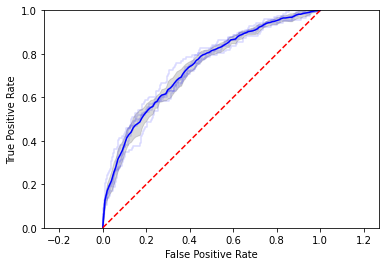

In [25]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: 'models_new/0/',
          1: 'models_new/1/',
          2: 'models_new/2/',
          3: 'models_new/3/',
          4: 'models_new/4/'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(5):
  print(iii)

  test_features= DATA[iii]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[iii]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[iii]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[iii]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))
  for x in listdir(models[iii]):
    #print(x)
    model = keras.models.load_model(models[iii]+x)
    y_score = model.predict(TEST)
    fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
    print('Num_samples:', len(y_score))

    print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()